# Train Continuous Control Agent for Reacher Environment

---

In this notebook, we'll train agent using DDPG algorithm.
We begin by importing some necessary packages and starting the environment.
If the code cell below returns an error, please revisit installation instructions given in the README.md.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 2. Train the Agent

In the next code cell, we define training procedure.

In [2]:
def train(env, brain_name, agent, target_avg_score=30, avg_window=100, update_every=20, update_cycles=20, eps_decay=0.999, eps_end=0.3, print_every=10):
    scores_deque = deque(maxlen=avg_window)
    scores = []
    eps = 1
    for i_episode in range(1, 1000):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = 0
        step = 0
        while True:
            # act
            actions = agent.act(states, noise_strength=eps)
            env_info = env.step(actions)[brain_name]
            # record action results
            next_states, rewards, dones = (env_info.vector_observations, env_info.rewards, env_info.local_done)
            agent.memorize(states, actions, rewards, next_states, dones)
            # each N steps, learn from recorded experiences
            if step % update_every == 0:
                agent.train(iterations=update_cycles)
            states = next_states
            # mean of all agents' scores
            score += np.mean(rewards)
            step += 1
            if np.any(dones):
                break

        scores_deque.append(score)
        scores.append(score)
        # mean over 'avg_window' episodes
        avg_score = np.mean(scores_deque)
        # update noise level
        eps = max(eps_end, eps * eps_decay)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tNoise: {:.4f}\tLast Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, eps, score, avg_score))
        if avg_score >= target_avg_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores



#### Start Training

Import agent code and run training procedure defined earlier.

In [3]:
# Import agent from 'src' folder.
import sys
sys.path.insert(0, 'src')
from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
scores = train(env, brain_name, agent)

Episode 10	Noise: 0.9900	Last Score: 1.02	Average Score: 0.59
Episode 20	Noise: 0.9802	Last Score: 5.93	Average Score: 2.15
Episode 30	Noise: 0.9704	Last Score: 12.72	Average Score: 4.98
Episode 40	Noise: 0.9608	Last Score: 22.10	Average Score: 9.52
Episode 50	Noise: 0.9512	Last Score: 27.60	Average Score: 13.01
Episode 60	Noise: 0.9417	Last Score: 34.86	Average Score: 16.65
Episode 70	Noise: 0.9324	Last Score: 35.35	Average Score: 19.37
Episode 80	Noise: 0.9231	Last Score: 33.87	Average Score: 20.70
Episode 90	Noise: 0.9139	Last Score: 21.31	Average Score: 21.66
Episode 100	Noise: 0.9048	Last Score: 20.37	Average Score: 22.32
Episode 110	Noise: 0.8958	Last Score: 34.35	Average Score: 25.89
Episode 120	Noise: 0.8869	Last Score: 29.51	Average Score: 28.67

Environment solved in 126 episodes!	Average Score: 30.08


#### Plot Scores

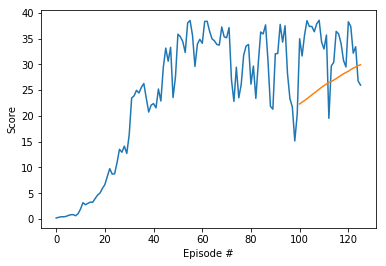

In [4]:
# Calculate average scores over 100 episodes
window = 100
avg_scores = []
for i in range(len(scores) - window):
    avg_scores.append(np.mean(scores[i:i + window]))
    
# Plot the scores and average
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(window, len(avg_scores) + window), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [5]:
env.close()